In this project, I will examine the neural collaborative filtering method to predict users ratings. In addition to embedding vectors for users and movies, user personal features and movie genres are taken as input features for training. 
I use MoveLens data from https://grouplens.org/datasets/movielens/1m/. 

Importing Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.layers import StringLookup
from keras.metrics import MeanSquaredError

Reading Data

In [4]:
ratings = pd.read_csv(
    "Data/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
)

movies = pd.read_csv(
    "Data/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
)

users = pd.read_csv(
    "Data/ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    encoding="ISO-8859-1",
    engine="python",
)

Cleaning Data

In [5]:
ratings.head(n=1)

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760


In [6]:
ratings['user_id'] = ratings['user_id'].apply(lambda x:f'user_{x}')
ratings['movie_id'] = ratings['movie_id'].apply(lambda x:f'movie_{x}')
ratings['rating'] = ratings['rating'].astype('float32') 
ratings['movie_num_rating'] = ratings.groupby('movie_id')['rating'].transform('count').astype('int')
ratings['movie_average_rating'] = ratings.groupby('movie_id')['rating'].transform('mean').round(3)
del ratings['unix_timestamp']

In [7]:
movies.head(n=1)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy


In [8]:
movies['movie_id'] = movies['movie_id'].apply(lambda x:f'movie_{x}')

movies_genres = movies.copy()
genres = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime"]
genres += ["Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical"]
genres += ["Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

for genre in genres:
    movies_genres[genre] = movies_genres["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )

In [9]:
users.head(n=1)

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067


In [10]:
users['user_id'] = users['user_id'].apply(lambda x:f'user_{x}')
users['age_group'] = users['age_group'].apply(lambda x:f'group_{x}')
users['occupation'] = users['occupation'].apply(lambda x:f'occupation_{x}')
del users['zip_code']

Creating Train/Validation/Test Datasets

In [11]:
data = ratings.merge(users)
data = data.loc[:,['user_id','sex','age_group','occupation','movie_id','rating']]

# creating train/validation/test datasets with an 80/10/10 split
train_data, temp = train_test_split(data, test_size=0.2)  
val_data, test_data = train_test_split(temp, test_size=0.5)

def dataframe_to_dataset(dataframe):
    labels = dataframe.pop('rating').to_frame()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

train_ds = dataframe_to_dataset(train_data)
val_ds = dataframe_to_dataset(val_data)
test_ds = tf.data.Dataset.from_tensor_slices(dict(test_data))

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

Creating Embeddings for Input Features

In [12]:
def create_model_inputs():
    return {
        "user_id": keras.Input(name="user_id", shape=(1,), dtype="string"),
        "sex": keras.Input(name="sex", shape=(1,), dtype="string"),
        "age_group": keras.Input(name="age_group", shape=(1,), dtype="string"),
        "occupation": keras.Input(name="occupation", shape=(1,), dtype="string"),
        "movie_id": keras.Input(name="movie_id", shape=(1,), dtype="string"),
    }

features = {
    "user_id": list(users.user_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
    "movie_id": list(movies.movie_id.unique()),
}

def encode_input_features(inputs):
    encoded_features = []
    
    for feature in features:
        # get list of every feature in features
        vocabulary = features[feature] 
        # convert the string input values into integer indices
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature]
        )
        # compute embedding dimensions
        embedding_dims = int(np.sqrt(len(vocabulary)))
        # create an embedding layer with the specified dimensions
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature}_embedding",
        )
        # convert the index values to embedding representations and add them to the list of encoded_features
        encoded_features.append(embedding_encoder(idx)) 
        # add embedding for genres
        if feature == 'movie_id':
            genre_vectors = movies_genres[genres].to_numpy()
            genres_embedding = layers.Embedding(
                input_dim=genre_vectors.shape[0],
                output_dim=genre_vectors.shape[1],
                embeddings_initializer=keras.initializers.Constant(genre_vectors),
                trainable=False,
                name="genres_vector",
            )
            encoded_features.append(genres_embedding(idx))

    # create a single embedding vector by concatenating embeddings of all input features
    encoded_features = layers.concatenate(encoded_features) 
    return encoded_features

In [13]:
hidden_units = [32,16,8]
dropout_rate = 0.1
learning_rate = 0.001
num_epochs = 30

def create_model():
    inputs = create_model_inputs()
    features = encode_input_features(inputs)
    
    # neural network
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def run_experiment(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    model.fit(train_ds, epochs=num_epochs)
    _, rmse = model.evaluate(val_ds, verbose=0)

    print(f'validation root mean squared error  = {rmse:.3f}')

In [19]:
model = create_model()
run_experiment(model)

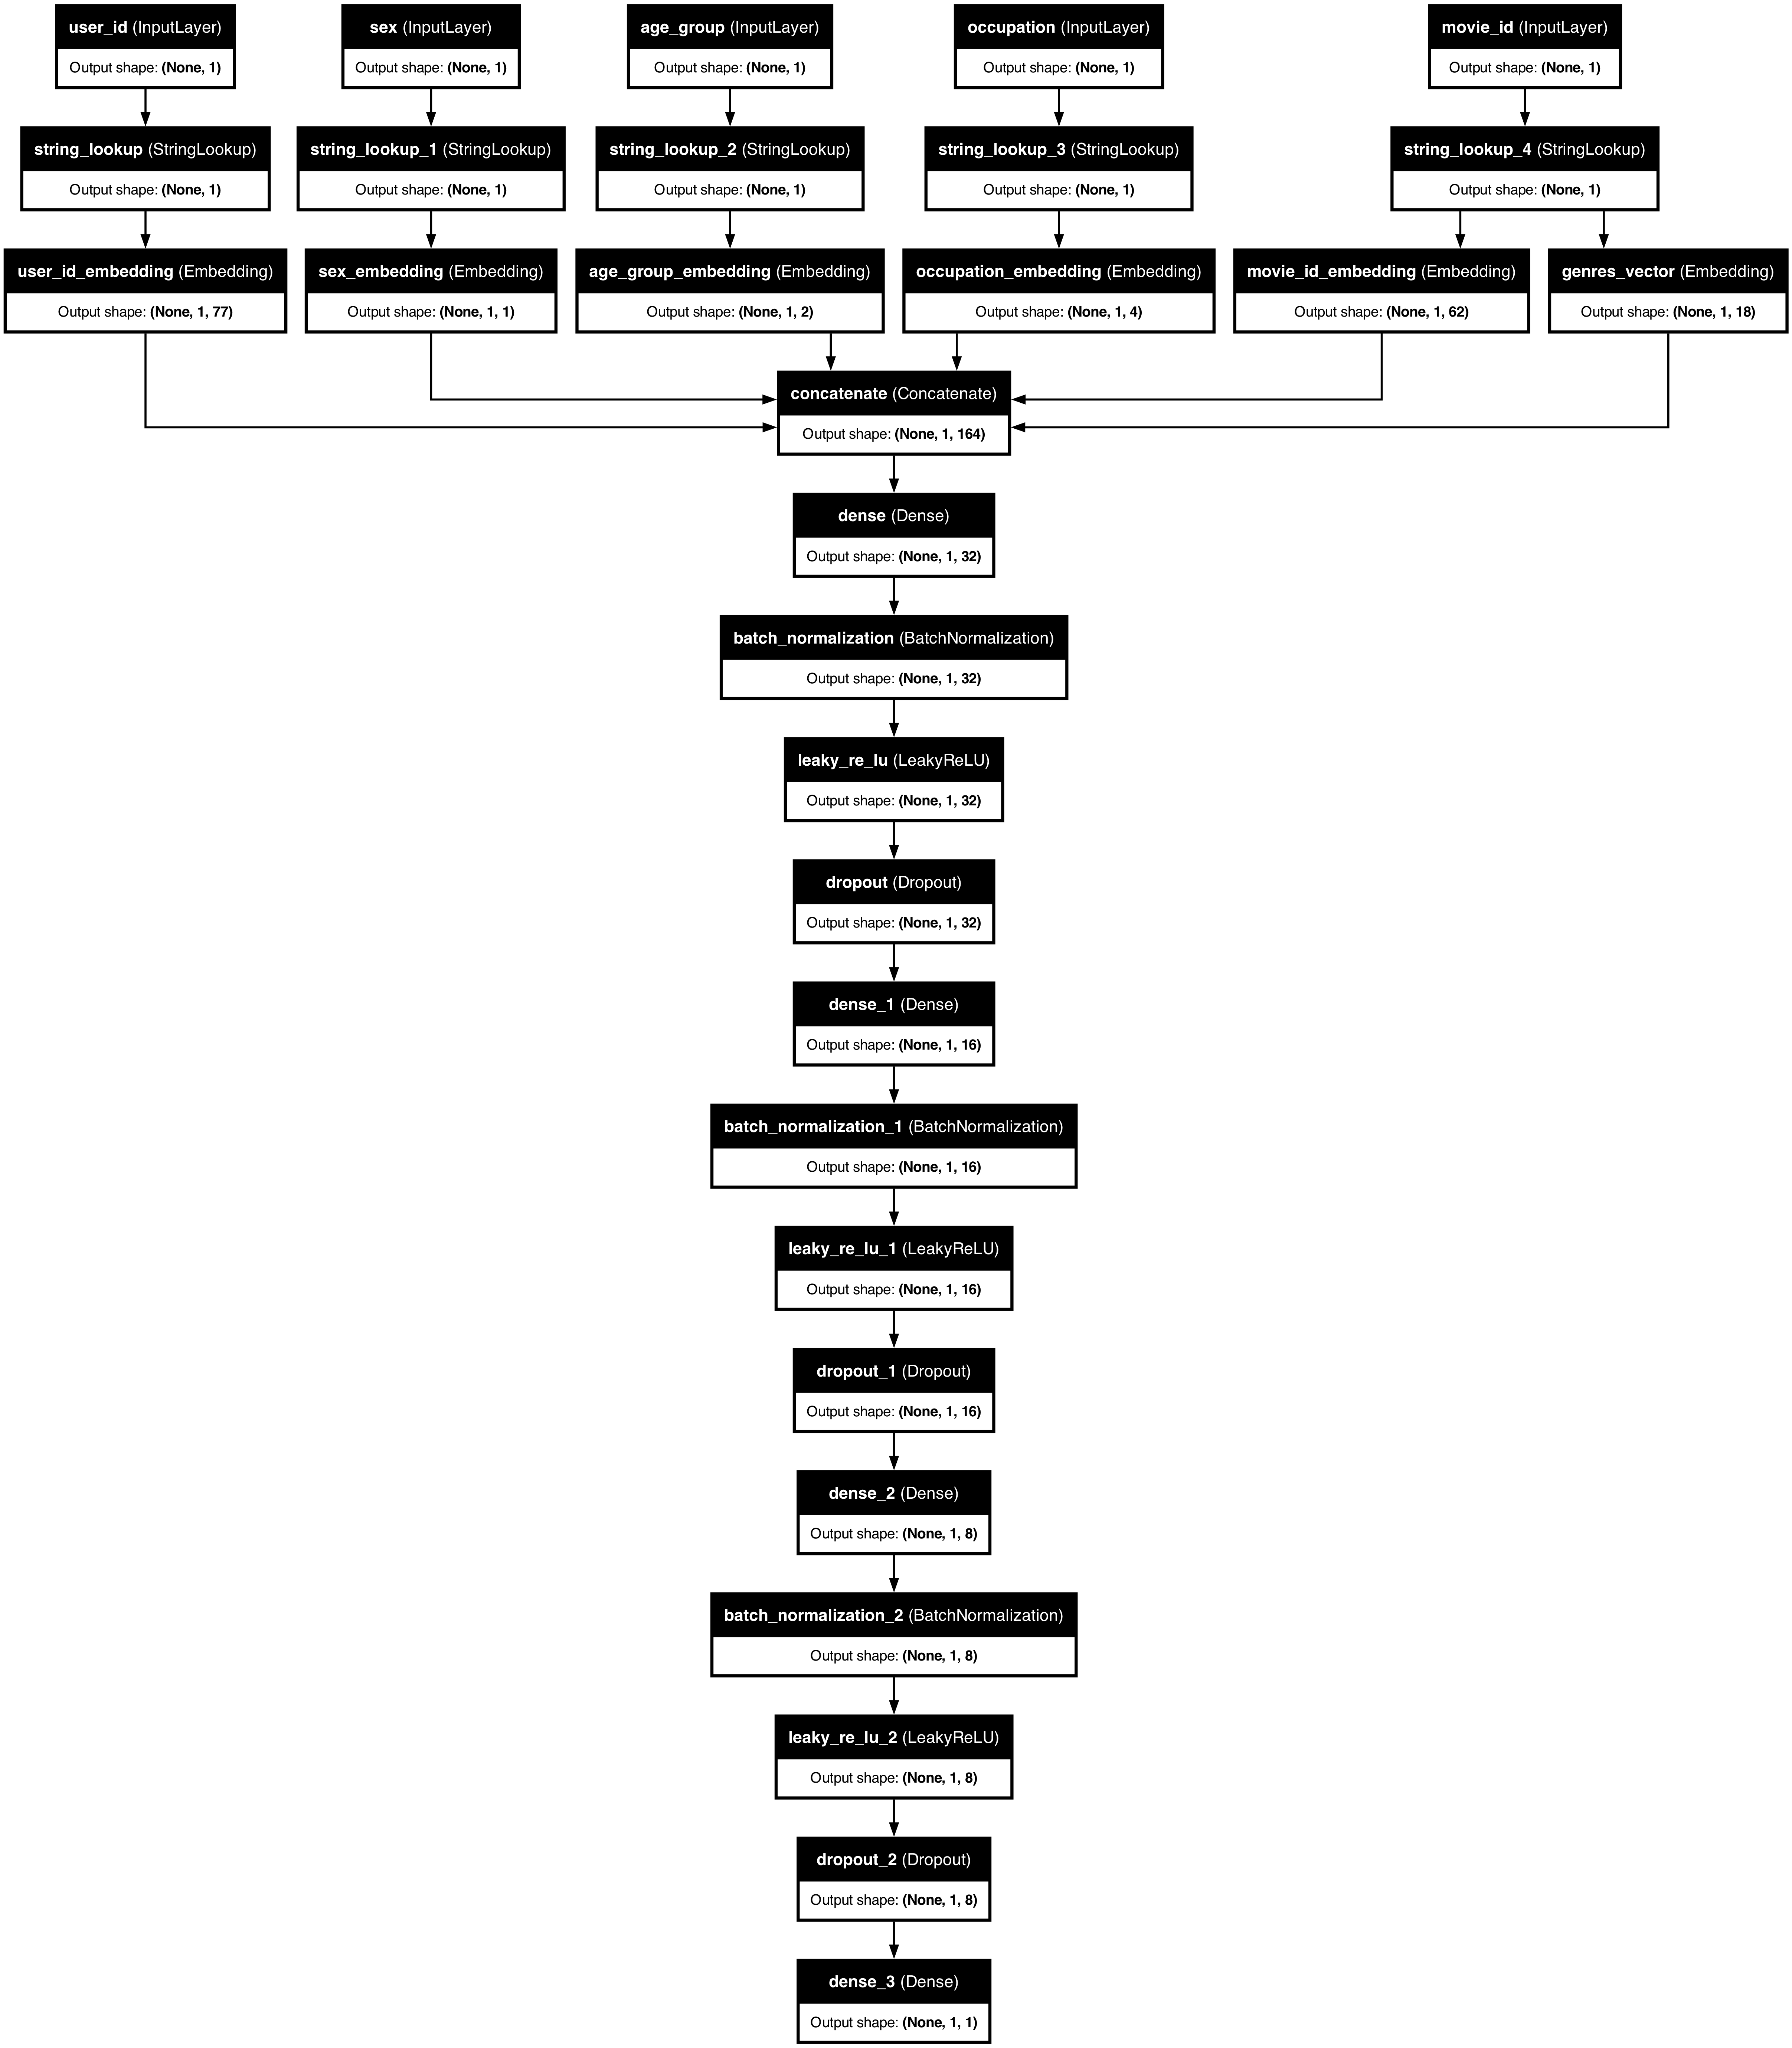

In [15]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Prediction on Test Data

The neural collaborative filtering has decreased test error by ~10%.

In [20]:
test_prediction = model.predict(test_ds)
test_error = np.sqrt(MeanSquaredError()(test_prediction[:,0,0], test_data['rating']))
print('test error: ',test_error.round(3))

base_prediction = ratings.iloc[list(test_data.index)]['movie_average_rating']
base_error = np.sqrt(MeanSquaredError()(base_prediction, test_data['rating']))
print('base error: ', base_error.round(3))

relative_error_reduction = (base_error - test_error)/base_error * 100
print(f'relative error reduction: {relative_error_reduction:.1f}%')

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
test error:  0.881
base error:  0.975
relative error reduction: 9.6%


Recommendations for a sample user

In [21]:
def predict_rating(sample, number_of_recommendation):
    # get feature values of the sample
    sample_id = sample['user_id'].values[0]
    sample_sex = sample['sex'].values[0]
    sample_age = sample['age_group'].values[0]
    sample_occupation = sample['occupation'].values[0]
    # get list of watched/not wathched movies by the sample
    sample_watched_movies = list(ratings[ratings.user_id == sample_id]['movie_id'])
    sample_not_watched_movies = [i for i in list(movies['movie_id'].unique()) if i not in sample_watched_movies]
    len_not_watched = len(sample_not_watched_movies)

    df = pd.DataFrame(
        {'user_id': [sample_id] * len_not_watched, 
         'sex': [sample_sex] * len_not_watched, 
         'age_group': [sample_age] * len_not_watched, 
         'occupation': [sample_occupation] * len_not_watched, 
         'movie_id': sample_not_watched_movies
         })
    
    ds = tf.data.Dataset.from_tensor_slices(dict(df))
    ds = ds.batch(256)
    # predict ratings for the sample and sort them by rating for best recommendations
    rating = model.predict(ds)
    prediction = pd.DataFrame({'movie_id': sample_not_watched_movies, 'rating': rating[:,0,0]})
    top_recommendations = prediction.sort_values(by='rating', ascending=False).head(n=number_of_recommendation)
    top_recommendations = top_recommendations.merge(movies)[['title']]
    
    # top ten movies watched by user 
    top_watched = data[data['user_id'] == sample_id][['movie_id', 'rating']]
    top_watched = top_watched.sort_values(by='rating', ascending=False).head(n=10)
    top_watched = top_watched.merge(movies)[['title']]

    return top_watched, top_recommendations

In [24]:
sample = data.sample(1)
top_watched, top_recommendations = predict_rating(sample,10)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [25]:
print('******************************************')
print('Best Watched Movies')
print('******************************************')
print(top_watched)
print('\n')
print('******************************************')
print('Top Recommendations')
print('******************************************')
print(top_recommendations)

******************************************
Best Watched Movies
******************************************
                                               title
0                             Very Bad Things (1998)
1                                 Matrix, The (1999)
2                                Animal House (1978)
3                                   Homegrown (1998)
4        South Park: Bigger, Longer and Uncut (1999)
5                           Perfect Murder, A (1998)
6                              Simple Plan, A (1998)
7                         Mission: Impossible (1996)
8  Austin Powers: International Man of Mystery (1...
9                          Fifth Element, The (1997)


******************************************
Top Recommendations
******************************************
                                 title
0  I Am Cuba (Soy Cuba/Ya Kuba) (1964)
1                      Lamerica (1994)
2                       Sanjuro (1962)
3               For All Mankind (1989)
4       